## LSTM Classifier

In [7]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))

0

In [30]:
import pandas as pd
import numpy as np
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint


Code to change progress bar color to dark from tqdm.

In [9]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

In [10]:
tqdm.pandas()
# Just a facy way of loading the data while being able to see the rows being loaded in real time. 
# Each value is in chunk size of 1000. So 2,471 chunks = 2,471,000 rows.
df = pd.DataFrame(pd.concat([chunk for chunk in tqdm(pd.read_csv('../data/reddit_depression_dataset_cleaned.csv', chunksize=1000, index_col=0), desc='Loading data')]))
df.head()

Loading data: 1988it [01:26, 22.94it/s]


label                 date  upvotes  num_comments  \
0    0.0  2014-07-14 03:35:09      4.0           0.0   
1    0.0  2014-09-13 00:31:19      4.0           1.0   
2    0.0  2014-11-20 04:31:58      6.0           1.0   
3    0.0  2014-11-20 19:38:05     25.0           2.0   
5    0.0  2014-11-22 19:17:39      8.0          23.0   

                                       combined_text  \
0  Deep thoughts underdog Only when we start cons...   
1  I like this sub, there's only two posts yet I ...   
2  Rebirth! Hello. \nI am the new guy in charge h...   
3  "I want to be like water. I want to slip throu...   
5  What is the limit of the knowledge and power a...   

                                      tokenized_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', ',', "there's", '...   
2  ['rebirth', '!', 'hello', '.', 'i', 'am', 'the...   
3  ['"', 'i', 'want', 'to', 'be', 'like', 'water'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                                       alphanum_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', 'only', 'two', 'p...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               stopword_removed_text  \
0  ['deep', 'thoughts', 'underdog', 'start', '99'...   
1  ['posts', 'coming', 'human', 'morality', 'joke...   
2  ['rebirth', 'guy', 'charge', 'thegood', 'ofc',...   
3  ['water', 'slip', 'fingers', 'hold', 'ship', '...   
5  ['limit', 'knowledge', 'power', 'human', 'pers...   

                                        stemmed_text  \
0  ['deep', 'thought', 'underdog', 'start', '99',...   
1  ['post', 'come', 'human', 'moral', 'joke', 'lo...   
2  ['rebirth', 'guy', 'charg', 'thegood', 'ofc', ...   
3  ['water', 'slip', 'finger', 'hold', 'ship', 'm...   
5  ['limit', 'knowledg', 'power', 'human', 'perso...   

                   non_stopword_removed_stemmed_text  \
0  ['deep', 'thought', 'underdog', 'onli', 'when'...   
1  ['i', 'like', 'thi', 'sub', 'onli', 'two', 'po...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               combined_stemmed_text  \
0  deep thought underdog start 99 underdog start ...   
1  post come human moral joke long abscenc hope d...   
2  rebirth guy charg thegood ofc bring weirdpinea...   
3         water slip finger hold ship michel william   
5     limit knowledg power human person infinit grow   

          combined_non_stopword_removed_stemmed_text  
0  deep thought underdog onli when we start consi...  
1  i like thi sub onli two post yet i keep come b...  
2  rebirth hello i am the new guy in charg here b...  
3  i want to be like water i want to slip through...  
5  what is the limit of the knowledg and power a ...

In [11]:
df.shape

(1987011, 12)

In [12]:
df['label'].unique()

array([0., 1.])

There are two main labels: `0` and `1`.

In [13]:
print(df[df['label'] == 0].shape)
print(df[df['label'] == 1].shape)

(1761649, 12)
(225362, 12)


### Data Processing

In [14]:
df.isnull().sum()

label                                             0
date                                              0
upvotes                                           0
num_comments                                      0
combined_text                                     0
tokenized_text                                    0
alphanum_text                                     0
stopword_removed_text                             0
stemmed_text                                      0
non_stopword_removed_stemmed_text                 0
combined_stemmed_text                         12190
combined_non_stopword_removed_stemmed_text     1046
dtype: int64

There are some missing values from the last two attributes.

In [15]:
df[df['combined_stemmed_text'].isnull()].head()

label                 date  upvotes  num_comments  \
314     0.0  2017-02-06 05:02:10      4.0           9.0   
526     0.0  2017-12-05 11:54:57      4.0           5.0   
999     0.0  2018-11-28 02:11:29      9.0           6.0   
1425    0.0  2019-05-28 10:55:26     11.0           5.0   
1906    0.0  2019-12-02 04:24:03      6.0           5.0   

                                          combined_text  \
314                 You have to be there to know there    
526   become one with what you want to get to where ...   
999    Everything is nothing if nothing is everything?    
1425  Do we actually know anyone? No one ever hardly...   
1906                             I am not who I am yet    

                                         tokenized_text  \
314   ['you', 'have', 'to', 'be', 'there', 'to', 'kn...   
526   ['become', 'one', 'with', 'what', 'you', 'want...   
999   ['everything', 'is', 'nothing', 'if', 'nothing...   
1425  ['do', 'we', 'actually', 'know', 'anyone', '?'...   
1906        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']   

                                          alphanum_text stopword_removed_text  \
314   ['you', 'have', 'to', 'be', 'there', 'to', 'kn...                    []   
526   ['become', 'one', 'with', 'what', 'you', 'want...                    []   
999   ['everything', 'is', 'nothing', 'if', 'nothing...                    []   
1425  ['do', 'we', 'actually', 'know', 'anyone', 'no...                    []   
1906        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']                    []   

     stemmed_text                  non_stopword_removed_stemmed_text  \
314            []  ['you', 'have', 'to', 'be', 'there', 'to', 'kn...   
526            []  ['becom', 'one', 'with', 'what', 'you', 'want'...   
999            []  ['everyth', 'is', 'noth', 'if', 'noth', 'is', ...   
1425           []  ['do', 'we', 'actual', 'know', 'anyon', 'no', ...   
1906           []        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']   

     combined_stemmed_text         combined_non_stopword_removed_stemmed_text  
314                    NaN                 you have to be there to know there  
526                    NaN  becom one with what you want to get to where y...  
999                    NaN                 everyth is noth if noth is everyth  
1425                   NaN  do we actual know anyon no one ever hardli sho...  
1906                   NaN                              i am not who i am yet

Upon further investigation, we can see that the text processing has deemed all its contents to be overly high frequency, and ended up omitting the entire text.

In [16]:
df = df.dropna(subset=['combined_stemmed_text'])
df.isnull().sum()

label                                         0
date                                          0
upvotes                                       0
num_comments                                  0
combined_text                                 0
tokenized_text                                0
alphanum_text                                 0
stopword_removed_text                         0
stemmed_text                                  0
non_stopword_removed_stemmed_text             0
combined_stemmed_text                         0
combined_non_stopword_removed_stemmed_text    0
dtype: int64

In cases like this, we can remove the rows that do not help us for this classification task.

In [17]:
print('Date:', type(df['date'][0]))
print('Upvotes:', type(df['upvotes'][0]))
print('Num Comments:', type(df['num_comments'][0]))
print('Stemmed Text:', type(df['stemmed_text'][0]))

Date: <class 'str'>
Upvotes: <class 'numpy.float64'>
Num Comments: <class 'numpy.float64'>
Stemmed Text: <class 'str'>


The two main attributes that need type conversions are `date` and `stemmed_text`.

In [18]:
df['date'] = pd.to_datetime(df['date'])
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
df['stemmed_text'] = df['stemmed_text'].progress_apply(ast.literal_eval)
type(df['stemmed_text'][0])

100%|██████████| 1974821/1974821 [01:59<00:00, 16534.74it/s]


list

In [20]:
df.head()

label                date  upvotes  num_comments  \
0    0.0 2014-07-14 03:35:09      4.0           0.0   
1    0.0 2014-09-13 00:31:19      4.0           1.0   
2    0.0 2014-11-20 04:31:58      6.0           1.0   
3    0.0 2014-11-20 19:38:05     25.0           2.0   
5    0.0 2014-11-22 19:17:39      8.0          23.0   

                                       combined_text  \
0  Deep thoughts underdog Only when we start cons...   
1  I like this sub, there's only two posts yet I ...   
2  Rebirth! Hello. \nI am the new guy in charge h...   
3  "I want to be like water. I want to slip throu...   
5  What is the limit of the knowledge and power a...   

                                      tokenized_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', ',', "there's", '...   
2  ['rebirth', '!', 'hello', '.', 'i', 'am', 'the...   
3  ['"', 'i', 'want', 'to', 'be', 'like', 'water'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                                       alphanum_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', 'only', 'two', 'p...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               stopword_removed_text  \
0  ['deep', 'thoughts', 'underdog', 'start', '99'...   
1  ['posts', 'coming', 'human', 'morality', 'joke...   
2  ['rebirth', 'guy', 'charge', 'thegood', 'ofc',...   
3  ['water', 'slip', 'fingers', 'hold', 'ship', '...   
5  ['limit', 'knowledge', 'power', 'human', 'pers...   

                                        stemmed_text  \
0  [deep, thought, underdog, start, 99, underdog,...   
1  [post, come, human, moral, joke, long, abscenc...   
2  [rebirth, guy, charg, thegood, ofc, bring, wei...   
3  [water, slip, finger, hold, ship, michel, will...   
5  [limit, knowledg, power, human, person, infini...   

                   non_stopword_removed_stemmed_text  \
0  ['deep', 'thought', 'underdog', 'onli', 'when'...   
1  ['i', 'like', 'thi', 'sub', 'onli', 'two', 'po...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               combined_stemmed_text  \
0  deep thought underdog start 99 underdog start ...   
1  post come human moral joke long abscenc hope d...   
2  rebirth guy charg thegood ofc bring weirdpinea...   
3         water slip finger hold ship michel william   
5     limit knowledg power human person infinit grow   

          combined_non_stopword_removed_stemmed_text  
0  deep thought underdog onli when we start consi...  
1  i like thi sub onli two post yet i keep come b...  
2  rebirth hello i am the new guy in charg here b...  
3  i want to be like water i want to slip through...  
5  what is the limit of the knowledg and power a ...

### Model Preperation

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['stemmed_text'])
print(tokenizer.word_index)

{'feel': 1, 'peopl': 2, 'fuck': 3, 'day': 4, 'friend': 5, 'guy': 6, 'time': 7, 'girl': 8, 'post': 9, 'school': 10, 'talk': 11, 'life': 12, 'year': 13, 'thing': 14, 'good': 15, 'love': 16, 'today': 17, 'shit': 18, 'depress': 19, 'start': 20, 'hate': 21, 'happi': 22, 'die': 23, 'live': 24, 'person': 25, 'wanna': 26, 'bad': 27, 'thought': 28, 'work': 29, 'crush': 30, 'gonna': 31, 'play': 32, 'reddit': 33, '2': 34, 'sleep': 35, 'kill': 36, 'care': 37, 'edit': 38, 'parent': 39, 'sad': 40, 'dont': 41, 'hour': 42, 'game': 43, 'filler': 44, 'class': 45, 'teenag': 46, 'watch': 47, 'mom': 48, 'week': 49, 'comment': 50, 'lot': 51, 'want': 52, 'happen': 53, 'suicid': 54, 'month': 55, 'hope': 56, 'meme': 57, 'told': 58, 'pretti': 59, 'night': 60, '3': 61, 'bore': 62, 'final': 63, 'song': 64, 'hey': 65, 'long': 66, 'question': 67, 'ask': 68, 'kid': 69, 'boy': 70, 'turn': 71, 'idk': 72, 'think': 73, 'reason': 74, 'hard': 75, 'listen': 76, 'stuff': 77, 'nice': 78, 'famili': 79, 'tire': 80, 'girlfriend

In [22]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 190287


In [23]:
sequences = tokenizer.texts_to_sequences(df['stemmed_text'])
max_length = max(len(seq) for seq in sequences)
print('Longest Sequence:', max_length)

Longest Sequence: 32


In [24]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Padded Sequences Shape:', padded_sequences.shape)

Padded Sequences Shape: (1974821, 32)


In [25]:
X = padded_sequences
y = df['label']
print(X.shape, y.shape)

(1974821, 32) (1974821,)


In [26]:
X[0]

array([  578,    28, 16858,    20,  1841, 16858,    20,  2522,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1579856, 32) (1579856,)
(394965, 32) (394965,)


### Model Building

Model 1: using a single LSTM layer

In [32]:
model1 = Sequential()
model1.add(layers.Embedding(vocab_size, 16))
model1.add(LSTM(40,dropout=0.5))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM1_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
49371/49371 [==============================] - 1092s 22ms/step - loss: 0.1472 - accuracy: 0.9438 - val_loss: 0.1354 - val_accuracy: 0.9473
Epoch 2/5
49371/49371 [==============================] - 1107s 22ms/step - loss: 0.1359 - accuracy: 0.9475 - val_loss: 0.1336 - val_accuracy: 0.9474
Epoch 3/5
49371/49371 [==============================] - 1105s 22ms/step - loss: 0.1332 - accuracy: 0.9485 - val_loss: 0.1336 - val_accuracy: 0.9482
Epoch 4/5
49371/49371 [==============================] - 1105s 22ms/step - loss: 0.1312 - accuracy: 0.9491 - val_loss: 0.1386 - val_accuracy: 0.9453
Epoch 5/5
49371/49371 [==============================] - 1106s 22ms/step - loss: 0.1300 - accuracy: 0.9497 - val_loss: 0.1452 - val_accuracy: 0.9430


In [41]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.9471 - loss: 0.1375
Test accuracy: 0.9475


In [42]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model1.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted/Classified: [[0.12215889]
 [0.08959608]
 [0.06643277]
 [0.00338965]
 [0.00454153]]


In [43]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model1.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted/Classified: [[0.31590664]
 [0.4743166 ]
 [0.7497709 ]
 [0.3528539 ]
 [0.01317841]]


12343/12343 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step


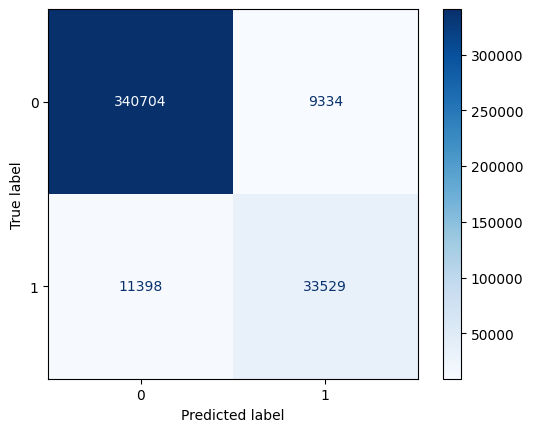

In [44]:
# Predict the labels for the test set
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy Score: 0.9475
F1 Score: 0.7638


Model 2: using 2 LSTM layer

In [33]:
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, 16))
model2.add(LSTM(40,dropout=0.5, return_sequences=True))
model2.add(LSTM(40,dropout=0.5))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM2_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
49371/49371 [==============================] - 1561s 31ms/step - loss: 0.1473 - accuracy: 0.9438 - val_loss: 0.1350 - val_accuracy: 0.9478
Epoch 2/5
49371/49371 [==============================] - 1581s 32ms/step - loss: 0.1370 - accuracy: 0.9471 - val_loss: 0.1331 - val_accuracy: 0.9486
Epoch 3/5
49371/49371 [==============================] - 1853s 38ms/step - loss: 0.1338 - accuracy: 0.9484 - val_loss: 0.1319 - val_accuracy: 0.9487
Epoch 4/5
49371/49371 [==============================] - 1612s 33ms/step - loss: 0.1319 - accuracy: 0.9491 - val_loss: 0.1603 - val_accuracy: 0.9436
Epoch 5/5
49371/49371 [==============================] - 1608s 33ms/step - loss: 0.1308 - accuracy: 0.9495 - val_loss: 0.1583 - val_accuracy: 0.9433


In [34]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 71s 6ms/step - loss: 0.1583 - accuracy: 0.9433
Test accuracy: 0.9433


In [ ]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model2.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted/Classified: [[0.12215889]
 [0.08959608]
 [0.06643277]
 [0.00338965]
 [0.00454153]]


In [35]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model2.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 [==============================] - 1s 636ms/step
Predicted/Classified: [[0.55143076]
 [0.8007121 ]
 [0.813128  ]
 [0.30291167]
 [0.05132082]]


12343/12343 [==============================] - 66s 5ms/step


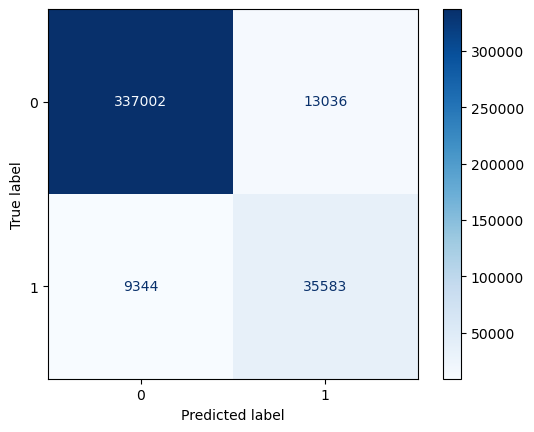

In [36]:
# Predict the labels for the test set
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [39]:
accuracy_model2 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model2:.4f}")
f1_model2 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model2:.4f}")

Accuracy Score: 0.9433
F1 Score: 0.7608


Model 3: fine tuned parameters

In [47]:
model3 = Sequential()
model3.add(layers.Embedding(vocab_size, 40))
model3.add(LSTM(64,dropout=0.3, return_sequences=True))
model3.add(LSTM(64,dropout=0.3))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM3_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model3.fit(X_train, y_train, epochs=2,validation_data=(X_test, y_test))

Epoch 1/2
49371/49371 [==============================] - 2929s 59ms/step - loss: 0.1420 - accuracy: 0.9457 - val_loss: 0.1336 - val_accuracy: 0.9479
Epoch 2/2
49371/49371 [==============================] - 2945s 60ms/step - loss: 0.1294 - accuracy: 0.9500 - val_loss: 0.1288 - val_accuracy: 0.9499


In [48]:
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 204s 16ms/step - loss: 0.1288 - accuracy: 0.9499
Test accuracy: 0.9499


In [49]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model3.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 [==============================] - 1s 1s/step
Predicted/Classified: [[0.03203812]
 [0.12195391]
 [0.03208051]
 [0.00395275]
 [0.00450476]]


In [50]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model3.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 [==============================] - 0s 48ms/step
Predicted/Classified: [[0.22709355]
 [0.7987477 ]
 [0.7775087 ]
 [0.43675122]
 [0.02516435]]


12343/12343 [==============================] - 196s 16ms/step


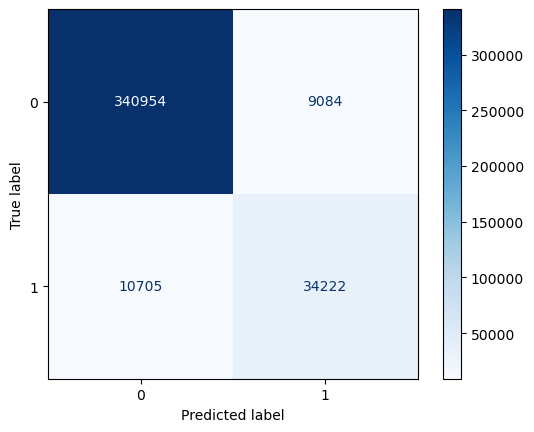

In [51]:
# Predict the labels for the test set
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [52]:
accuracy_model3 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model3:.4f}")
f1_model3 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model3:.4f}")

Accuracy Score: 0.9499
F1 Score: 0.7757


Model 4: fine tuned using bidirectional layers

In [54]:
model4 = Sequential()
model4.add(layers.Embedding(vocab_size, 40))
model4.add(layers.Bidirectional(LSTM(64,dropout=0.3, return_sequences=True)))
model4.add(layers.Bidirectional(LSTM(64,dropout=0.3)))
model4.add(Dense(1,activation='sigmoid'))

model4.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM4_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model4.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test))

49371/49371 [==============================] - 3819s 77ms/step - loss: 0.1378 - accuracy: 0.9469 - val_loss: 0.1285 - val_accuracy: 0.9501


In [55]:
test_loss, test_accuracy = model4.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 151s 12ms/step - loss: 0.1285 - accuracy: 0.9501
Test accuracy: 0.9501


In [56]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model4.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 [==============================] - 1s 961ms/step
Predicted/Classified: [[0.04384762]
 [0.12276338]
 [0.02896327]
 [0.00274947]
 [0.00907423]]


In [57]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model4.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 [==============================] - 0s 21ms/step
Predicted/Classified: [[0.1654419 ]
 [0.694118  ]
 [0.683849  ]
 [0.33042708]
 [0.01865277]]


12343/12343 [==============================] - 152s 12ms/step


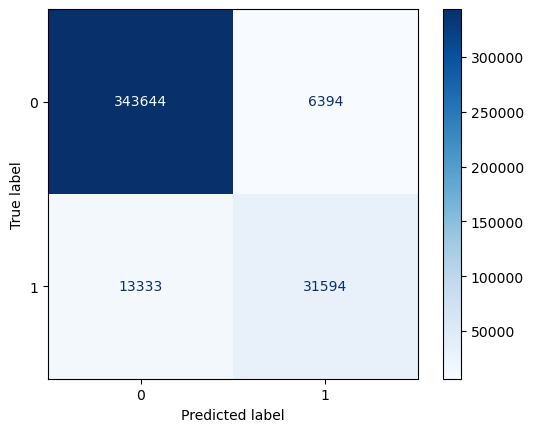

In [58]:
# Predict the labels for the test set
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [59]:
accuracy_model4 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model4:.4f}")
f1_model4 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model4:.4f}")

Accuracy Score: 0.9501
F1 Score: 0.7621
